# Modèle de traduction Transformer avec attention

## Installation

Quand il s'agit d'entraîner des modèles d'apprentissage profond, en particulier les modèles basés sur les Transformers, le calcul est souvent intensif. Les GPUs NVIDIA, grâce à leur architecture parallèle, sont parfaitement adaptés à ces tâches. Ainsi, vérifier la disponibilité et les spécifications d'un GPU NVIDIA est essentiel pour s'assurer que l'environnement d'exécution est optimisé pour l'entraînement.

Les bibliothèques comme TensorFlow nécessitent souvent des jeux de données et des outils supplémentaires pour traiter le texte. tensorflow_datasets offre une variété de jeux de données standardisés prêts à l'emploi, ce qui simplifie grandement la préparation des données. D'autre part, tensorflow_text est une extension de TensorFlow qui facilite le traitement du texte en fournissant des outils et des opérations spécifiques à cette tâche.

L'importation de différents modules standard de Python facilite la manipulation des données, l'interaction avec le système d'exploitation et la gestion des erreurs.

In [1]:
# Affiche les détails du GPU NVIDIA pour s'assurer qu'il est disponible.
!nvidia-smi

# Installe la bibliothèque tensorflow_datasets, qui offre un ensemble de jeux de données prêts à être utilisés avec TensorFlow.
!pip install tensorflow_datasets

# Met à jour et installe la bibliothèque tensorflow-text, utile pour certaines opérations de traitement du texte avec TensorFlow.
!pip install -U tensorflow-text

# Importe divers modules Python standard et bibliothèques nécessaires.
import collections      # Fournit des structures de données alternatives comme les dictionnaires, les ensembles et les listes.
import logging          # Facilite la génération de journaux pour suivre le déroulement de l'exécution.
import os               # Permet d'interagir avec le système d'exploitation, par exemple pour gérer les chemins de fichiers.
import pathlib          # Offre une interface orientée objet pour gérer les systèmes de fichiers et les chemins.
import re               # Fournit des fonctions pour travailler avec des expressions régulières.
import string           # Contient des opérations courantes sur les chaînes.
import sys              # Fournit un accès à certaines variables et fonctions utilisées par l'interpréteur Python.
import time             # Fournit des fonctions liées au temps, comme la pause et la mesure du temps d'exécution.

# Importe les bibliothèques pour la manipulation de données et la visualisation.
import numpy as np      # Bibliothèque pour le calcul scientifique avec Python.
import matplotlib.pyplot as plt  # Bibliothèque pour la création de visualisations et de graphiques.

# Importe des bibliothèques spécifiques à TensorFlow.
import tensorflow_datasets as tfds  # Fournit un accès aux jeux de données.
import tensorflow_text as text      # Bibliothèque pour le traitement du texte avec TensorFlow.
import tensorflow as tf             # Importe TensorFlow lui-même.

# Affiche le nom du GPU utilisé par TensorFlow, s'il est disponible.
print(tf.test.gpu_device_name())

# Configure le module de journalisation de TensorFlow pour supprimer les avertissements.
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Thu Aug  3 16:10:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Télécharger le jeu de données


### Aspect théorique:

Les jeux de données sont la pierre angulaire de tout projet d'apprentissage automatique. Dans le contexte de la traduction automatique, il est essentiel de disposer de paires de phrases alignées dans les langues source et cible pour entraîner le modèle.

La base de données 'ted_hrlr_translate/pt_to_en' de TensorFlow Datasets (TFDS) provient des transcriptions des conférences TED et offre des paires de phrases en plusieurs langues. En particulier, 'pt_to_en' fait référence aux paires de traduction du portugais vers l'anglais. Ces données sont idéales pour entraîner un modèle de traduction car elles contiennent des phrases réelles issues de conférences professionnelles.

### Aspect pratique:

1. **Chargement des données**: La fonction `tfds.load` est utilisée pour télécharger et charger le jeu de données `ted_hrlr_translate/pt_to_en` dans des variables. Cette fonction est très puissante car elle gère à la fois le téléchargement, le stockage et la mise en cache des données. L'argument `with_info=True` demande également des métadonnées sur le jeu de données.

2. **Séparation des données**: Les données sont généralement divisées en plusieurs ensembles pour différents usages. Ici, `examples['train']` et `examples['validation']` fournissent respectivement les données d'entraînement et de validation. La séparation en ensembles d'entraînement et de validation permet d'entraîner le modèle sur un sous-ensemble de données, puis de le valider sur un ensemble différent pour évaluer ses performances.

3. **Affichage d'échantillons**: Pour avoir une idée de la nature des données, quelques exemples sont extraits et affichés. La méthode `.batch(3).take(1)` permet d'extraire le premier batch de 3 exemples. Les méthodes `numpy()` et `decode('utf-8')` sont ensuite utilisées pour convertir les tensors TensorFlow en chaînes de caractères pour l'affichage.

In [2]:
# Charger le jeu de données 'pt_to_en' (portugais à anglais) de TED HRLR Translate
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

# Séparer les données en données d'entraînement et de validation
train_examples, val_examples = examples['train'], examples['validation']

# Afficher quelques exemples de phrases en portugais et en anglais
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteLPNFOZ/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteLPNFOZ/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteLPNFOZ/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Tokénisation et détokénisation de texte


### Aspect théorique:

La tokénisation est le processus de conversion d'une chaîne de texte en une séquence de tokens (par exemple, des mots, des sous-mots ou des caractères). C'est une étape essentielle dans le traitement du texte pour l'apprentissage automatique car les modèles fonctionnent sur des représentations numériques plutôt que sur des chaînes de caractères brutes. De plus, la tokénisation permet une meilleure gestion des mots inconnus ou rares en les décomposant en sous-units plus fréquentes. La détokénisation est le processus inverse : convertir une séquence de tokens en une chaîne de texte.

### Aspect pratique:

1. **Acquisition du modèle de tokénisation**: Le nom du modèle est spécifié (`"ted_hrlr_translate_pt_en_converter"`) et est téléchargé à partir d'une URL prédéfinie. Il est sauvegardé localement après le téléchargement.

2. **Chargement du modèle**: Une fois le modèle téléchargé, il est chargé en mémoire à l'aide de `tf.saved_model.load`. Ce modèle contient les informations nécessaires pour tokéniser le texte en portugais et en anglais.

3. **Exploration des méthodes disponibles**: Pour se familiariser avec les fonctionnalités fournies par le modèle de tokénisation, une liste de méthodes disponibles est affichée, en excluant les méthodes privées (celles qui commencent par un underscore).

4. **Tokénisation**: Les phrases en anglais (`en_examples`) sont tokenisées à l'aide de `tokenizers.en.tokenize`, transformant chaque phrase en une séquence de tokens.

5. **Visualisation des tokens**: Les séquences tokenisées sont affichées pour avoir une idée de la transformation.

6. **Détokénisation**: Pour vérifier la précision de la tokénisation, les tokens sont convertis en texte à l'aide de la méthode `detokenize`. Cette étape confirme que le processus de tokénisation (et sa méthode inverse) fonctionne correctement.

7. **Affichage des tokens**: Enfin, le modèle de tokénisation est utilisé pour récupérer la représentation textuelle de chaque token.

En somme, cette section traite de la préparation du texte pour l'entraînement. Elle garantit que le texte est correctement transformé en tokens, qui sont les unités fondamentales sur lesquelles le modèle sera formé.

In [3]:
# Nom du modèle pour la tokenisation
model_name = "ted_hrlr_translate_pt_en_converter"

# Télécharge le modèle de tokenisation
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

# Charge le modèle de tokenisation
tokenizers = tf.saved_model.load(model_name)

# Liste les méthodes disponibles pour le tokenizer en anglais
[item for item in dir(tokenizers.en) if not item.startswith('_')]

# Imprime des exemples encodés
for en in en_examples.numpy():
  print(en.decode('utf-8'))

# Tokenise les exemples
encoded = tokenizers.en.tokenize(en_examples)

# Imprime les exemples tokenisés
for row in encoded.to_list():
  print(row)

# Détokenise les exemples pour revenir au texte original
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

# Regarde les tokens utilisés pour l'encodage
tokens = tokenizers.en.lookup(encoded)
tokens

184801/184801 [==============================] - 0s 2us/step
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

## Configurer le pipeline d'entrée


### Aspect théorique:

L'un des aspects les plus importants de la formation d'un modèle de deep learning, en particulier avec les données textuelles, est le traitement et la préparation de ces données. Le code ci-dessus établit un pipeline d'entrée pour gérer ce processus.

- **Tokenisation**: Au cœur de ce pipeline se trouve le processus de tokenisation. La tokenisation est la conversion d'une séquence de caractères en une séquence de tokens. Ces tokens peuvent être aussi petits qu'un caractère ou aussi grands qu'un mot. En transformant le texte en tokens, on obtient une représentation numérique du texte, qui peut ensuite être traitée par le modèle.

- **Batching et mélange**: Dans le contexte de l'apprentissage machine, un batch est un sous-ensemble de l'ensemble de données d'entraînement utilisé pour mettre à jour les poids du modèle. Le mélange est crucial pour assurer que le modèle ne voit pas toujours les échantillons dans le même ordre, ce qui pourrait créer un biais. Le code utilise également un buffer pour le mélange, garantissant que les échantillons tirés pour le prochain batch sont pris au hasard d'un ensemble de `BUFFER_SIZE` échantillons.

### Aspect pratique:

- **Fonction `tokenize_pairs`**: Cette fonction prend en entrée des paires de phrases en portugais (pt) et en anglais (en). Elle utilise des tokeniseurs spécifiques pour chaque langue pour convertir ces phrases en tokens. Après la tokenisation, la sortie peut avoir une forme dite "ragged", c'est-à-dire que chaque phrase tokenisée peut avoir une longueur différente. Pour éviter cela, et rendre les données compatibles avec les opérations de deep learning, la sortie est convertie en un tensor dense, où les phrases plus courtes sont complétées par des zéros pour atteindre une longueur uniforme.

- **Fonction `make_batches`**: Après avoir défini la fonction de tokenisation, vous avez la fonction `make_batches`. Cette fonction, comme son nom l'indique, est utilisée pour créer des lots d'échantillons. Ces étapes sont essentielles pour préparer les données pour l'entraînement :
  - **`.cache()`**: Cette fonction stocke les éléments du jeu de données en mémoire, accélérant considérablement les étapes ultérieures.
  - **`.shuffle(BUFFER_SIZE)`**: Elle mélange les échantillons pour éviter que le modèle ne voit toujours les mêmes séquences, ce qui pourrait créer un biais.
  - **`.batch(BATCH_SIZE)`**: Elle regroupe les échantillons en lots de taille `BATCH_SIZE`.
  - **`.map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)`**: Elle applique la fonction de tokenisation à chaque élément du jeu de données. L'utilisation de `num_parallel_calls` permet un traitement parallèle, accélérant considérablement le processus.
  - **`.prefetch(tf.data.AUTOTUNE)`**: Elle précharge les données pour éviter les temps d'attente lors de l'entraînement.

Enfin, j'ai créé des lots pour les jeux de données d'entraînement et de validation en utilisant la fonction `make_batches`.

In [4]:
# Fonction pour tokeniser les paires de phrases (pt et en)
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convertit de ragged à dense, avec remplissage de zéros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convertit de ragged à dense, avec remplissage de zéros.
    en = en.to_tensor()
    return pt, en

# Paramètres pour le traitement par lots et le mélange
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# Crée des lots pour le jeu de données
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

# Crée les lots d'entraînement et de validation
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Encodage positionnel


Dans les architectures de traitement de séquence, en particulier le Transformer, l'ordre des mots est d'une importance cruciale. L'encodage positionnel est un mécanisme qui permet aux modèles de prendre en compte l'ordre des mots dans une séquence, même lorsqu'ils ne comportent pas de mécanismes de récurrence ou de convolution.

**Aspect théorique**:

- **Pourquoi l'encodage positionnel?** : Les architectures basées sur des transformateurs n'utilisent ni récurrence ni convolutions, elles ne disposent donc pas d'une notion intrinsèque de l'ordre des séquences. Pour remédier à cela, j'intègre une information positionnelle supplémentaire à chaque entrée pour indiquer sa position dans la séquence.

- **Comment cela fonctionne-t-il?** : L'encodage positionnel est réalisé en utilisant une combinaison de fonctions sinus et cosinus à différentes fréquences. Cela permet d'obtenir une représentation unique pour chaque position de la séquence qui peut ensuite être sommée avec l'embedding du mot pour fournir à la fois une information sémantique (de l'embedding) et positionnelle (de l'encodage positionnel).

**Aspect pratique**:

- **Fonction `get_angles`** : Elle calcule les taux d'angle pour l'encodage. Ces taux sont dérivés en fonction de la position et de la dimension de l'embedding. Ils garantissent que chaque position a un encodage unique.

- **Fonction `positional_encoding`** : Cette fonction génère l'encodage positionnel en utilisant à la fois des fonctions sinus et cosinus. L'utilisation du sinus et du cosinus à différentes fréquences garantit que l'encodage est unique pour chaque position et reste interprétable même pour de longues séquences.

- **Visualisation** : Après avoir généré l'encodage, j'ai visualisé l'encodage pour montrer comment il varie en fonction de la position. L'encodage est dense avec des oscillations qui varient en amplitude et en fréquence, ce qui rend chaque position unique. De plus, j'ai également fourni une visualisation séparée pour les fonctions sinus et cosinus pour une dimension spécifique, offrant ainsi une perspective plus détaillée sur la manière dont chaque fonction contribue à l'encodage global.

En fin de compte, l'encodage positionnel est un outil puissant pour intégrer l'information positionnelle dans les modèles qui, autrement, manqueraient de cette capacité. Cela permet aux modèles comme le Transformer d'obtenir des performances impressionnantes sur des tâches de traitement de séquence.

(1, 2048, 512)


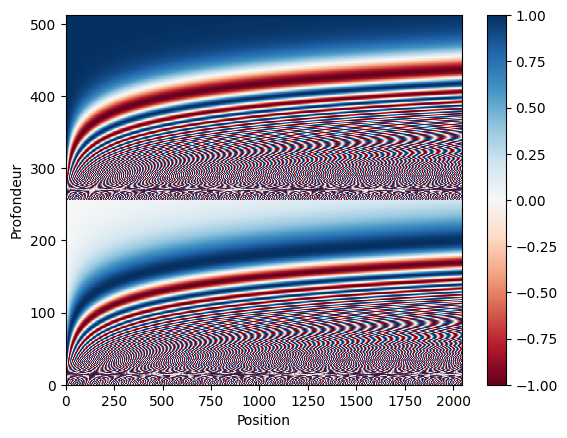

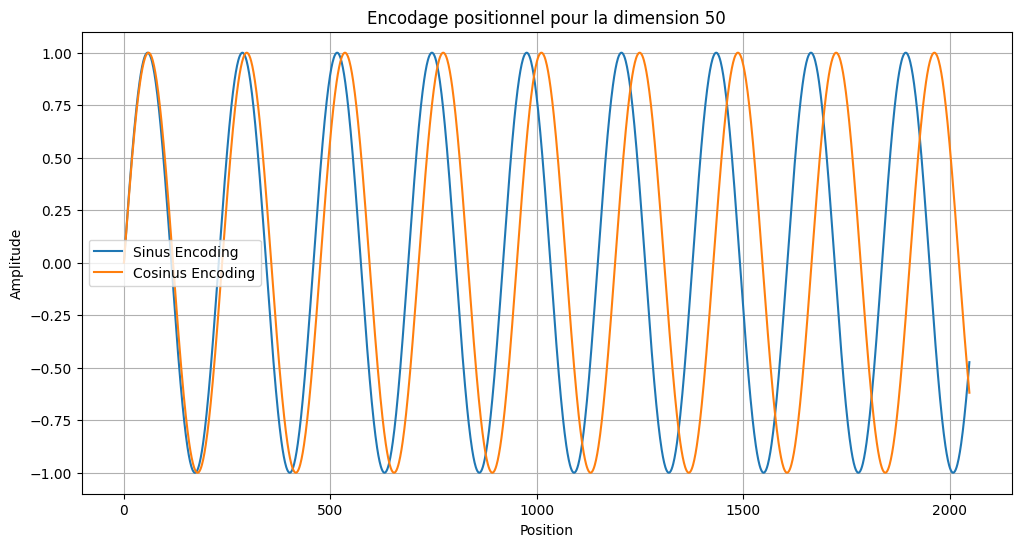

In [5]:
# Fonction pour calculer les angles de l'encodage positionnel
def get_angles(pos, i, d_model):
  # Calcule les taux d'angle pour l'encodage
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  # Renvoie la multiplication des positions et des taux d'angle
  return pos * angle_rates

# Fonction pour générer l'encodage positionnel
def positional_encoding(position, d_model):
  # Calcul des angles radiaux pour l'encodage positionnel
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  # Applique la fonction sinus aux colonnes à indices pairs
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # Applique la fonction cosinus aux colonnes à indices impairs
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  # Ajoute une nouvelle dimension à angle_rads
  pos_encoding = angle_rads[np.newaxis, ...]

  # Retourne l'encodage positionnel sous forme de tensor
  return tf.cast(pos_encoding, dtype=tf.float32)

# Création et affichage de l'encodage positionnel
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
# Reshape et transpose pour la visualisation
pos_encoding = pos_encoding[0]
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))
# Visualisation de l'encodage positionnel
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Profondeur')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Visualisation séparée des fonctions sinus et cosinus
plt.figure(figsize=(12, 6))

# Sélectionnez une dimension spécifique à visualiser
dim_to_visualize = 50
# Si vous souhaitez visualiser une autre dimension, changez simplement la valeur de dim_to_visualize

plt.plot(pos_encoding[2 * dim_to_visualize, :], label='Sinus Encoding')
plt.plot(pos_encoding[2 * dim_to_visualize + 1, :], label='Cosinus Encoding')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title(f'Encodage positionnel pour la dimension {dim_to_visualize}')
plt.legend()
plt.grid(True)
plt.show()

## Masquage


La capacité d'un modèle à traiter séquentiellement des informations est essentielle, notamment lors de la prédiction de mots ou de tokens suivants dans une séquence. C'est là qu'interviennent les mécanismes de masquage. Ils permettent d'ignorer certains tokens ou de s'assurer que lors de la prédiction d'un token à un certain pas de temps, seules les informations précédentes (ou valides) sont utilisées.

**Aspect théorique**:

- **Pourquoi le masquage?** : Lors de la formation d'un modèle de séquence, il peut y avoir des situations où certaines parties de la séquence ne doivent pas contribuer à l'apprentissage, soit parce qu'elles ne sont pas pertinentes (comme les paddings), soit parce qu'elles pourraient donner des informations sur le futur lors de la prédiction.

- **Types de masques** :
  1. **Masque de Padding**: Dans les séquences, tous les exemples d'un lot n'ont pas nécessairement la même longueur. Pour gérer cela, on utilise un mécanisme de "padding" pour rendre toutes les séquences de la même taille. Cependant, ces valeurs "paddées" ne doivent pas contribuer à l'apprentissage, d'où la nécessité d'un masque de padding.
  2. **Masque Look-ahead**: Lors de la prédiction d'un token, on ne devrait avoir accès qu'aux tokens précédents, et non aux suivants. Le masque look-ahead garantit cela en masquant tous les tokens futurs dans une séquence.

**Aspect pratique**:

- **Fonction `create_padding_mask`** : Cette fonction identifie les zéros (paddings) dans une séquence et crée un masque pour eux. Si une position dans la séquence est un zéro (padding), alors le masque aura une valeur de 1 pour cette position, indiquant qu'elle doit être masquée.

- **Fonction `create_look_ahead_mask`** : Cette fonction crée un masque triangulaire supérieur. Cela garantit que lors de la prédiction d'un token à un pas de temps spécifique, tous les tokens futurs sont masqués.

- **Exemples** : J'ai fourni des exemples pour démontrer comment ces fonctions créent des masques. Par exemple, le masque de padding pour une séquence avec des zéros montrera où se trouvent les paddings, et le masque look-ahead pour une séquence montrera une forme triangulaire, masquant tous les tokens après le token actuel.

En somme, le masquage est crucial pour s'assurer que les modèles traitent les données de manière appropriée, en ignorant les paddings et en s'assurant que lors de la prédiction, seules les informations valides sont utilisées.

In [6]:
# Fonction pour créer un masque de padding
def create_padding_mask(seq):
  # Identifie les zéros dans la séquence
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # Retourne le masque pour la séquence
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# Exemple de création de masque de padding
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

# Fonction pour créer un masque look-ahead
def create_look_ahead_mask(size):
  # Crée un masque triangulaire supérieur
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Exemple de création de masque look-ahead
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Attention au produit scalaire mis à l'échelle


**Aspect théorique**:

L'attention du produit scalaire mis à l'échelle est un mécanisme qui permet à un modèle de focaliser différents niveaux d'attention sur différentes parties d'une séquence. C'est l'ingrédient clé derrière l'architecture Transformer, qui a révolutionné les tâches de traitement du langage naturel.

- **Pourquoi "mis à l'échelle"?** : Lorsque la dimension de la clé (ou la profondeur) est grande, le produit scalaire entre la requête et la clé peut être très grand. Cela peut pousser la fonction softmax à avoir des gradients très faibles, rendant le modèle difficile à entraîner. La mise à l'échelle par \( \sqrt{d_k} \) est une astuce pour contrecarrer cela.

- **Comment cela fonctionne-t-il?** : On commence par calculer le produit scalaire des requêtes avec toutes les clés. Ensuite, chaque valeur est mise à l'échelle et un masque optionnel peut être ajouté avant d'appliquer la fonction softmax pour obtenir les poids d'attention. Enfin, ces poids sont utilisés pour obtenir une combinaison pondérée des valeurs.

**Aspect pratique**:

- **Fonction `scaled_dot_product_attention`** :
  1. Calcule le produit scalaire entre la requête `q` et la clé `k`.
  2. Met cette valeur à l'échelle avec \( \sqrt{d_k} \), où \( d_k \) est la dimension de la clé.
  3. Si un masque est fourni, on l'ajoute (généralement pour masquer les valeurs de padding ou pour le masquage look-ahead).
  4. Applique la fonction softmax pour obtenir les poids d'attention.
  5. Multiplie les poids d'attention par la valeur `v` pour obtenir le résultat final.

- **Fonction `print_out`** : Il s'agit d'une fonction d'assistance pour afficher les poids d'attention et les résultats pour des requêtes, des clés et des valeurs fournies.

- **Exemples d'utilisation** : Plusieurs exemples de requêtes, clés et valeurs sont fournis pour montrer comment fonctionne le mécanisme d'attention. Chaque exemple illustre comment différentes requêtes accordent une attention différente à l'ensemble des clés.

En résumé, l'attention du produit scalaire mis à l'échelle est un mécanisme permettant à un modèle de pondérer l'importance de différentes parties d'une séquence lors de la prise de décisions. Ces poids d'attention peuvent être interprétés comme la mesure dans laquelle le modèle "prête attention" à différentes parties de l'entrée.

In [7]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calcule les poids d'attention.

    Arguments:
        q: forme de la requête == (..., seq_len_q, depth)
        k: forme de la clé == (..., seq_len_k, depth)
        v: forme de la valeur == (..., seq_len_v, depth_v)
        mask: tensor de flottants avec forme adaptable
              à (..., seq_len_q, seq_len_k). Par défaut à None.

    Retour:
        output, attention_weights
    """
    # Calcule le produit scalaire de q et k
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # Échelle matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # Si un masque est fourni, l'ajoute
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    # Calcule les poids d'attention
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # Obtenir le tensor de sortie en multipliant les poids et v
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Fonction pour afficher les résultats d'attention
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Les poids d’attention sont :')
    print(temp_attn)
    print('Le résultat est :')
    print(temp_out)

# Exemples d'utilisation
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0], [0, 10, 0], [0, 0, 10], [0, 0, 10]], dtype=tf.float32)
temp_v = tf.constant([[1, 0], [10, 0], [100, 5], [1000, 6]], dtype=tf.float32)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

# Quelques exemples de requêtes.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Les poids d’attention sont :
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Le résultat est :
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Les poids d’attention sont :
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Le résultat est :
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Les poids d’attention sont :
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Le résultat est :
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Les poids d’attention sont :
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Le résultat est :
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
Les poids d’attention sont :
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Le résultat est :
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Attention multi-tête


**Aspect théorique**:

L'attention multi-tête est une technique pour améliorer la capacité du mécanisme d'attention à se focaliser sur différentes parties d'une séquence simultanément. Plutôt que d'avoir une seule série de poids d'attention, l'attention multi-tête utilise plusieurs "têtes" pour capturer divers types d'informations relationnelles.

- **Pourquoi "multi-tête"?** : Chaque "tête" d'attention pourrait potentiellement apprendre à se concentrer sur différents aspects des données. En combinant les résultats de plusieurs têtes, on obtient une représentation qui capture diverses relations dans les données.

**Aspect pratique**:

- **Classe `MultiHeadAttention`** : C'est une couche Keras personnalisée qui réalise l'attention multi-tête.

  1. **Initialisation** : Les paramètres essentiels sont `d_model` (la dimension du modèle) et `num_heads` (le nombre de têtes d'attention). La classe s'assure que `d_model` est divisible par `num_heads`. Elle initialise également les couches denses pour les requêtes, les clés, et les valeurs, ainsi qu'une couche dense finale pour combiner les sorties des têtes d'attention.
  
  2. **`split_heads`** : Cette méthode prend un tensor et le réorganise pour qu'il ait des dimensions séparées pour les têtes d'attention et la profondeur.
  
  3. **`call`** : Cette méthode est appelée lorsqu'un tensor est passé à une instance de `MultiHeadAttention`. Elle effectue les étapes suivantes :
     - Passe les requêtes, clés, et valeurs à travers leurs couches denses respectives.
     - Organise les sorties pour les têtes d'attention.
     - Calcule l'attention du produit scalaire mis à l'échelle pour chaque tête.
     - Combine (ou concatène) les sorties des têtes d'attention.
     - Passe le résultat combiné à travers la couche dense finale.

- **Exemple d'utilisation** : Le code crée une instance `temp_mha` de la classe `MultiHeadAttention` avec une dimension de modèle de 512 et 8 têtes d'attention. Il passe ensuite un tensor `y` à cette instance et affiche les formes de la sortie et des poids d'attention.

En résumé, l'attention multi-tête permet à un modèle d'attention de se concentrer simultanément sur différentes parties d'une séquence, capturant ainsi une gamme plus riche d'informations relationnelles.

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # Nombre de têtes pour l'attention multi-tête
        self.d_model = d_model  # Dimension du modèle

        # Assure que la dimension du modèle est divisible par le nombre de têtes
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # Calcul de la profondeur de chaque tête

        # Couches denses pour les requêtes, les clés et les valeurs
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)  # Couche dense finale

    def split_heads(self, x, batch_size):
        """Divise la dernière dimension en (num_heads, depth).
        Transpose le résultat pour obtenir la forme (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Passage des requêtes, clés et valeurs à travers les couches denses
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Divise les requêtes, clés et valeurs pour l'attention multi-tête
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Calcule l'attention échelonnée
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Fusion des têtes d'attention
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # Passe l'attention concaténée à travers une dernière couche dense
        output = self.dense(concat_attention)

        return output, attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Réseau d'alimentation en aval point par point


**Aspect théorique** :

Le réseau d'alimentation en aval point par point (aussi connu sous le nom de réseau feed-forward positionnel) est une composante essentielle des transformateurs, une architecture populaire pour le traitement du langage naturel. Bien qu'il soit relativement simple, il joue un rôle crucial pour transformer les représentations produites par les mécanismes d'attention.

- **Caractéristiques** : Le réseau consiste en deux couches denses (ou fully connected) en série. La première couche dilate les dimensions pour un nombre spécifié (typiquement plus grand que la dimension d'entrée), et la deuxième les réduit à la dimension d'origine. La fonction d'activation ReLU est couramment utilisée entre les deux couches.

**Aspect pratique** :

- **Fonction `point_wise_feed_forward_network`** : Cette fonction construit et renvoie un modèle Keras pour le réseau feed-forward positionnel.

  1. **Paramètres** :
     - `d_model` : La dimension de la sortie (et généralement de l'entrée). Dans l'architecture des transformateurs, cela correspond à la dimension du modèle.
     - `dff` : La dimension de la couche cachée. C'est la dimension après la première couche dense avant la réduction à `d_model` par la deuxième couche.
  
  2. **Structure du modèle** :
     - Première couche : Une couche dense qui étend la dimension à `dff` et utilise une activation ReLU.
     - Deuxième couche : Une couche dense qui réduit la dimension à `d_model`.

- **Exemple d'utilisation** : Le code crée un exemple de ce réseau avec une dimension de modèle de 512 et une dimension de couche cachée de 2048. Il passe ensuite un tensor de forme (64, 50, 512) à travers ce réseau et affiche la forme de la sortie.

En résumé, le réseau d'alimentation en aval point par point est une composante standard des transformateurs qui transforme les représentations sans regarder les dépendances entre les différents éléments de la séquence, contrairement aux mécanismes d'attention.

In [9]:
def point_wise_feed_forward_network(d_model, dff):
    # Crée un réseau feed-forward pour le modèle point par point
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # Première couche dense
        tf.keras.layers.Dense(d_model)  # Deuxième couche dense
    ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encodeur et décodeur


### Couche d'encodeur


**Aspect théorique** :

Chaque couche d'encodeur dans le modèle "Transformer" contient principalement deux sous-couches : l'attention multi-tête et le réseau d'alimentation en aval point par point. L'attention multi-tête permet à l'encodeur de se concentrer sur différents mots de la séquence d'entrée de manière adaptative, tandis que le réseau feed-forward transforme ces représentations sans considération pour les relations inter-éléments.

- **Normalisation et Dropout** : Les mécanismes de normalisation des couches et de dropout sont essentiels pour éviter le surapprentissage et faciliter la convergence pendant l'entraînement.

**Aspect pratique** :

- **Classe `EncoderLayer`** : Cette classe définit une couche d'encodeur.

  1. **Constructeur** :
     - `d_model` : La dimension de la sortie.
     - `num_heads` : Le nombre de têtes pour l'attention multi-tête.
     - `dff` : La dimension de la couche cachée du réseau feed-forward.
     - `rate` : Le taux de dropout.

  2. **Sous-couches** :
     - `mha` : L'attention multi-tête.
     - `ffn` : Le réseau feed-forward point par point.
     - `layernorm1` et `layernorm2` : Normalisations des couches.
     - `dropout1` et `dropout2` : Couches dropout.

  3. **Méthode `call`** : La méthode d'appel traite les données d'entrée à travers toutes les sous-couches. L'attention est suivie par la normalisation et le dropout. Ensuite, le résultat passe par le réseau feed-forward, puis une autre normalisation et un dropout. La connexion résiduelle est utilisée pour ajouter l'entrée aux sorties des sous-couches d'attention et de feed-forward, respectivement.

- **Exemple d'utilisation** : Le code crée un exemple d'une couche d'encodeur avec une dimension de modèle de 512, huit têtes pour l'attention, et une dimension de couche cachée de 2048. Il passe ensuite un tensor de forme (64, 43, 512) à travers cette couche d'encodeur et affiche la forme de la sortie.

En résumé, la couche d'encodeur est une composante essentielle de l'architecture "Transformer" et est typiquement empilée plusieurs fois pour former l'encodeur complet dans le modèle "Transformer". Elle joue un rôle crucial pour transformer les représentations d'entrée en utilisant l'attention multi-tête et le réseau d'alimentation en aval point par point.

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        # Couches pour l'attention multi-tête et le réseau feed-forward point par point
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalisations des couches et des "dropout"
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        # Attention multi-tête
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Réseau feed-forward point par point
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### Couche décodeur


**Aspect théorique** :

Dans l'architecture Transformer, chaque couche de décodeur se compose de trois sous-couches majeures: deux blocs d'attention multi-têtes et un réseau d'alimentation en aval point par point.

1. Le **premier bloc d'attention** multi-têtes fonctionne comme dans l'encodeur, avec la particularité de disposer d'un mécanisme pour éviter de se concentrer sur les positions futures (c'est le rôle du "look-ahead mask").

2. Le **deuxième bloc d'attention** multi-têtes est utilisé pour que le décodeur concentre son attention sur les sorties pertinentes de l'encodeur. Autrement dit, le décodeur reçoit les sorties de l'encodeur et essaie de les associer à sa propre entrée pour mieux déduire la sortie suivante.

3. Le **réseau d'alimentation en aval** point par point fonctionne de manière similaire à celui de l'encodeur.

**Aspect pratique** :

- **Classe `DecoderLayer`** : Cette classe définit une couche de décodeur.

  1. **Constructeur** :
     - `d_model` : La dimension de la sortie.
     - `num_heads` : Le nombre de têtes pour l'attention multi-tête.
     - `dff` : La dimension de la couche cachée du réseau feed-forward.
     - `rate` : Le taux de dropout.

  2. **Sous-couches** :
     - `mha1` et `mha2` : Les deux blocs d'attention multi-têtes.
     - `ffn` : Le réseau feed-forward point par point.
     - `layernorm1`, `layernorm2`, et `layernorm3` : Normalisations des couches.
     - `dropout1`, `dropout2`, et `dropout3` : Couches dropout.

  3. **Méthode `call`** : Cette méthode passe les entrées à travers toutes les sous-couches. Chaque sous-couche est suivie d'une normalisation et d'un dropout. Les connexions résiduelles sont également utilisées pour ajouter l'entrée aux sorties des sous-couches.

- **Exemple d'utilisation** : Le code crée un exemple d'une couche de décodeur avec une dimension de modèle de 512, huit têtes pour l'attention, et une dimension de couche cachée de 2048. Il traite ensuite un tensor de forme (64, 50, 512) à travers cette couche de décodeur et affiche la forme de la sortie.

En résumé, la couche de décodeur est une autre composante essentielle de l'architecture Transformer. Elle transforme les représentations de l'encodeur en utilisant l'attention multi-tête (deux fois) et le réseau d'alimentation en aval point par point pour générer la sortie finale. Cette couche est également empilée plusieurs fois pour former le décodeur complet dans le modèle Transformer.

In [11]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # Couches pour l'attention multi-tête (x2) et le réseau feed-forward point par point
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Normalisations des couches et des "dropout"
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        # Première attention multi-tête
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # Deuxième bloc d'attention multi-têtes avec les sorties de l'encodeur comme clés et valeurs.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # Normalisation et addition résiduelle.

        # Réseau feed-forward point par point.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # Normalisation et addition résiduelle.

        # La sortie est la représentation transformée avec les poids d'attention de deux blocs.
        return out3, attn_weights_block1, attn_weights_block2

# Création et test d'un exemple de couche décodeur.
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None, None)
print(sample_decoder_layer_output.shape)  # Affiche la forme de la sortie : (batch_size, target_seq_len, d_model)

(64, 50, 512)


### Encodeur


**Aspect théorique** :

L'encodeur dans l'architecture Transformer prend une séquence d'entrée, la transforme en embeddings, lui ajoute des informations positionnelles et passe cette représentation combinée à travers une pile de couches d'encodeur.

Chaque couche d'encodeur contient principalement deux sous-couches : une attention multi-têtes et un réseau feed-forward point par point. Les sorties de chaque couche sont traitées avec une normalisation de couche et un dropout pour éviter le surapprentissage. La sortie d'une couche est ajoutée à son entrée (connexion résiduelle) avant d'être passée à la couche suivante.

**Aspect pratique** :

- **Classe `Encoder`** : Cette classe définit l'encodeur.

  1. **Constructeur** :
     - `num_layers` : Nombre de couches d'encodeurs.
     - `d_model` : La dimension de la sortie.
     - `num_heads` : Le nombre de têtes pour l'attention multi-tête.
     - `dff` : La dimension de la couche cachée du réseau feed-forward.
     - `input_vocab_size` : Taille du vocabulaire d'entrée.
     - `maximum_position_encoding` : Dimension maximale pour l'encodage positionnel.
     - `rate` : Le taux de dropout.
  
  2. **Sous-couches** :
     - `embedding` : Convertit les ID de mots en vecteurs.
     - `pos_encoding` : Ajoute des informations positionnelles aux embeddings.
     - `enc_layers` : Une pile de couches d'encodeurs.
     - `dropout` : Une couche dropout.

  3. **Méthode `call`** : Cette méthode traite l'entrée à travers l'embedding, l'encodage positionnel et les couches d'encodeurs.

- **Exemple d'utilisation** : Le code crée un exemple d'encodeur avec deux couches, une dimension de modèle de 512, huit têtes pour l'attention, une dimension de couche cachée de 2048, une taille de vocabulaire d'entrée de 8500 et un encodage positionnel maximal de 10000. Il traite ensuite un tensor d'entrée à travers cet encodeur et affiche la forme de la sortie.

En résumé, l'encodeur est responsable de la transformation des séquences d'entrée en une représentation continue qui contient des informations à la fois sur chaque mot individuel et sur leur position dans la séquence. Cette représentation est ensuite utilisée par le décodeur pour générer la séquence de sortie.

In [12]:
# Classe pour l'encodeur
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Initialisation de l'embedding des mots et de l'encoding des positions
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Création des couches d'encodeurs
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Ajout de l'embedding et de l'encoding des positions
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # Passer x à travers les couches d'encodeurs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # Retourne la sortie de l'encodeur

# Exemple de l'encodeur
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
print(sample_encoder_output.shape)  # Affiche la forme de la sortie

(64, 62, 512)


### Décodeur


**Aspect théorique** :

Le décodeur dans l'architecture Transformer est responsable de prendre la sortie de l'encodeur et de produire une séquence cible. Tout comme l'encodeur, le décodeur est composé de couches superposées. Cependant, chaque couche de décodeur a trois sous-couches principales : deux couches d'attention multi-tête (l'une utilisée pour l'attention par rapport aux sorties de l'encodeur et l'autre pour l'attention par rapport à la sortie de la couche précédente du décodeur) et une couche feed-forward point par point.

**Aspect pratique** :

- **Classe `Decoder`** :
  1. **Constructeur** :
     - `num_layers` : Nombre de couches de décodeurs.
     - `d_model` : La dimension de la sortie.
     - `num_heads` : Le nombre de têtes pour l'attention multi-tête.
     - `dff` : La dimension de la couche cachée du réseau feed-forward.
     - `target_vocab_size` : Taille du vocabulaire cible.
     - `maximum_position_encoding` : Dimension maximale pour l'encodage positionnel.
     - `rate` : Le taux de dropout.
  
  2. **Sous-couches** :
     - `embedding` : Convertit les ID de mots en vecteurs.
     - `pos_encoding` : Ajoute des informations positionnelles aux embeddings.
     - `dec_layers` : Une pile de couches de décodeurs.
     - `dropout` : Une couche dropout.

  3. **Méthode `call`** : Cette méthode traite l'entrée (qui est la séquence cible jusqu'au pas de temps précédent) à travers l'embedding, l'encodage positionnel, et les couches de décodeurs. Les sorties de l'encodeur sont également passées aux couches de décodeurs pour effectuer l'attention.

- **Exemple d'utilisation** : Un décodeur exemple est créé avec deux couches, une dimension de modèle de 512, huit têtes pour l'attention, une dimension de couche cachée de 2048, une taille de vocabulaire cible de 8000, et un encodage positionnel maximal de 5000. Il traite ensuite un tensor d'entrée à travers ce décodeur et affiche la forme de la sortie ainsi que celle des poids d'attention.

Pour faire simple, le décodeur génère progressivement la séquence cible en prêtant attention à sa propre sortie précédente et à la sortie de l'encodeur simultanément. Ces informations combinées lui permettent de générer le prochain élément de la séquence cible.

In [13]:
# Classe pour le décodeur
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Initialisation de l'embedding des mots et de l'encoding des positions
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Création des couches de décodeurs
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Ajout de l'embedding et de l'encoding des positions
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # Passer x à travers les couches de décodeurs
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights  # Retourne la sortie du décodeur et les poids d'attention

# Exemple de décodeur
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
output, attn = sample_decoder(temp_input, enc_output=sample_encoder_output, training=False, look_ahead_mask=None, padding_mask=None)
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Créer le transformateur


**Aspect théorique** :

Le transformateur est une architecture de traitement de séquences qui utilise des mécanismes d'attention pour mieux capturer les relations contextuelles à différentes portées dans une séquence. Contrairement aux architectures RNN et LSTM, le transformateur ne dépend pas des calculs séquentiels, ce qui le rend plus parallélisable et donc potentiellement plus rapide. L'architecture est composée de deux composants principaux : un encodeur et un décodeur.

- **Encodeur** : Il prend en entrée une séquence et la transforme en une sortie continue qui capture le contexte de chaque élément de la séquence.
  
- **Décodeur** : Il prend en entrée la sortie de l'encodeur et produit une nouvelle séquence.

**Aspect pratique** :

- **Classe `Transformer`** :
  1. **Constructeur** :
     - `num_layers`, `d_model`, `num_heads`, `dff`, `input_vocab_size`, `target_vocab_size`, `pe_input`, `pe_target`, `rate` : Ces paramètres définissent la taille, la forme et le comportement du modèle de transformateur.
     - `encoder` : Initialise l'encodeur.
     - `decoder` : Initialise le décodeur.
     - `final_layer` : Une couche dense qui convertit la sortie du décodeur en prédictions de taille `target_vocab_size`.
  
  2. **Méthode `call`** : Cette méthode prend en entrée des séquences d'entrée et cible, crée des masques appropriés, passe l'entrée à travers l'encodeur, la sortie de l'encodeur et la séquence cible à travers le décodeur, et finalement passe la sortie du décodeur à travers la `final_layer` pour obtenir les prédictions finales.

  3. **Méthode `create_masks`** : Cette méthode crée les masques nécessaires pour le traitement, notamment le masque de remplissage et le "look ahead" mask.

- **Exemple d'utilisation** : Un transformateur exemple est créé avec des paramètres donnés, puis est testé avec des séquences d'entrée et cible générées aléatoirement. La forme de la sortie est ensuite affichée.

En résumé, le transformateur est une architecture puissante et flexible pour le traitement de séquences, particulièrement adaptée aux tâches de traduction automatique, mais elle est également utilisée dans diverses autres tâches de traitement du langage naturel.

In [14]:
# Classe pour le modèle complet du transformateur
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        enc_padding_mask = create_padding_mask(inp)
        dec_padding_mask = create_padding_mask(inp)
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

# Exemple du transformateur
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, target_vocab_size=8000, pe_input=10000, pe_target=6000)
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)
fn_out, _ = sample_transformer([temp_input, temp_target], training=False)
fn_out.shape

TensorShape([64, 36, 8000])

## Définir des hyperparamètres


**Aspect théorique** :

Les hyperparamètres sont des paramètres qui ne sont pas appris pendant l'entraînement d'un modèle, mais qui sont définis à l'avance. Ils influencent la performance, la capacité et le comportement d'un modèle. Voici une brève description des hyperparamètres fournis :

- **`num_layers`** : Nombre de couches dans l'encodeur et le décodeur. Cela détermine la profondeur du modèle. Plus il y a de couches, plus le modèle peut potentiellement apprendre de représentations complexes, mais cela augmente aussi le risque de sur-entraînement et le temps d'entraînement.

- **`d_model`** : Dimension du modèle, c'est-à-dire la taille des représentations ou des embeddings à chaque couche. Une dimension plus élevée permet au modèle de représenter des données plus complexes, mais peut également augmenter le risque de sur-entraînement.

- **`dff`** : Dimension de la couche intermédiaire dans le réseau feed-forward. Cela influence la capacité du réseau à apprendre des transformations complexes entre les couches.

- **`num_heads`** : Nombre de têtes dans l'attention multi-têtes. L'attention multi-têtes permet au modèle de se concentrer sur différentes parties d'une séquence simultanément, ce qui peut améliorer la performance pour certaines tâches.

- **`dropout_rate`** : Probabilité de supprimer une unité pendant l'entraînement. Le dropout est une technique de régularisation qui peut aider à prévenir le sur-entraînement.

**Aspect pratique** :

Ces hyperparamètres sont généralement déterminés par une combinaison d'expérience, de connaissance du domaine et d'expérimentation. Parfois, une recherche d'hyperparamètres (comme une recherche sur grille ou une recherche bayésienne) est effectuée pour trouver la meilleure combinaison pour une tâche donnée.

Dans l'exemple donné :
- On utilise 4 couches pour l'encodeur et le décodeur.
- La dimension des embeddings est de 128.
- La couche feed-forward intermédiaire a une dimension de 512.
- L'attention multi-têtes est configurée avec 8 têtes.
- Le taux de dropout est de 0,1, ce qui signifie que pendant l'entraînement, chaque unité (neurone) a une probabilité de 10% d'être éliminée à chaque mise à jour du modèle.

En général, la configuration de ces hyperparamètres peut avoir un impact significatif sur la performance du modèle, et il est donc important de les choisir judicieusement.

In [15]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimiseur


**Aspect théorique** :

L'optimiseur est l'algorithme utilisé pour mettre à jour les paramètres d'un modèle en réponse à l'erreur qu'il produit pendant l'entraînement. L'optimiseur Adam est une variante de l'algorithme de descente de gradient stochastique qui calcule des taux d'apprentissage adaptatifs pour chaque paramètre.

Dans le Transformateur, une technique couramment utilisée est d'ajuster le taux d'apprentissage au cours de l'entraînement en utilisant une planification d'apprentissage spéciale. Cette planification augmente le taux d'apprentissage linéairement pour les premières `warmup_steps` étapes, puis le diminue proportionnellement à l'inverse de la racine carrée de l'étape.

**Aspect pratique** :

- La **classe CustomSchedule** définit cette planification d'apprentissage. Elle prend en compte la dimension du modèle `d_model` et le nombre d'étapes d'échauffement `warmup_steps`.

- Lors de l'instanciation de `CustomSchedule`, vous pouvez spécifier `d_model` et `warmup_steps` (qui a une valeur par défaut de 4000).

- L'optimiseur **Adam** est ensuite initialisé avec ce taux d'apprentissage personnalisé. Les paramètres `beta_1`, `beta_2` et `epsilon` sont des hyperparamètres typiques de l'optimiseur Adam.

- La visualisation à la fin montre comment le taux d'apprentissage évolue avec les étapes d'entraînement. Au début, le taux d'apprentissage augmente, mais après un certain nombre d'étapes (`warmup_steps`), il commence à diminuer.

Cette approche spéciale pour le taux d'apprentissage a été utilisée dans le papier original du Transformateur et est pensée pour offrir de meilleures performances, en particulier dans les tâches de traitement du langage naturel comme la traduction. Cependant, comme pour tous les hyperparamètres et techniques d'entraînement, la pertinence et l'efficacité peuvent varier en fonction de la tâche et des données spécifiques à laquelle le modèle est appliqué.

Text(0.5, 0, "Étape d'entrainement")

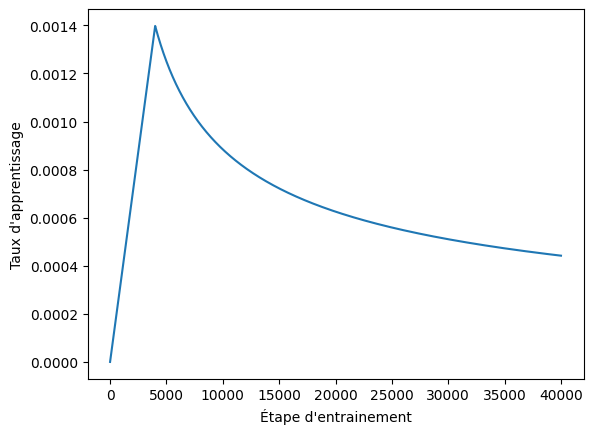

In [16]:
# Définition d'une classe pour un planning d'apprentissage personnalisé
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    # Initialisation du modèle dimensionnel
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    # Initialisation des étapes d'échauffement
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    # Convertir le tenseur step en flottant (float32)
    step = tf.cast(step, tf.float32)

    # Calcul des arguments pour la planification de l'apprentissage
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    # Retourne la valeur du taux d'apprentissage pour l'étape donnée
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Instanciation du taux d'apprentissage personnalisé
learning_rate = CustomSchedule(d_model)

# Initialisation de l'optimiseur Adam avec le taux d'apprentissage personnalisé
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Visualisation de la courbe de taux d'apprentissage
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Taux d'apprentissage")
plt.xlabel("Étape d'entrainement")

## Perte et mesures


**Aspect théorique** :

La **perte** est une mesure qui quantifie à quel point les prédictions du modèle s'éloignent des valeurs réelles. La fonction de perte choisie ici est la `SparseCategoricalCrossentropy`, qui est couramment utilisée pour les tâches de classification où les classes sont mutuellement exclusives.

La **précision** est une métrique qui quantifie le pourcentage de prédictions correctes par rapport à toutes les prédictions.

**Aspect pratique** :

- L'objet **loss_object** est une instance de `SparseCategoricalCrossentropy`. Il calcule la perte en croisement catégoriel entre les étiquettes réelles et les prédictions. L'argument `from_logits=True` signifie que la fonction s'attend à ce que les prédictions soient des logits non normalisés plutôt que des probabilités normalisées.

- La fonction **loss_function** est une version personnalisée de la fonction de perte qui prend en compte les séquences de padding (valeurs nulles). Le padding est utilisé pour que toutes les séquences aient la même longueur lors de l'entraînement, mais nous ne voulons pas inclure ces valeurs de padding lors du calcul de la perte. Pour cela, un masque est créé pour identifier ces valeurs de padding et les exclure du calcul de la perte.

- De même, la fonction **accuracy_function** calcule la précision tout en excluant les séquences de padding du calcul.

- **train_loss** et **train_accuracy** sont des métriques qui suivront et moyenneront la perte et la précision respectivement au cours de l'entraînement. Elles sont initialisées avec `tf.keras.metrics.Mean` pour accumuler les valeurs et calculer leur moyenne sur le temps.

Dans le contexte de la formation des modèles de traitement du langage naturel, la prise en compte de ces séquences de padding est essentielle pour obtenir des évaluations précises de la performance du modèle. Ces fonctions personnalisées permettent d'assurer que le modèle est évalué uniquement sur les éléments pertinents de la séquence et non sur le padding ajouté.

In [17]:
# Objet pour calculer la perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Fonction de perte personnalisée
def loss_function(real, pred):
  # Création d'un masque pour les séquences non nulles
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  # Application du masque à la perte
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # Retour de la perte moyenne
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# Fonction pour calculer la précision
def accuracy_function(real, pred):
  # Comparaison des valeurs réelles avec les prédictions
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  # Création d'un masque pour les séquences non nulles
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  # Application du masque aux précisions
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  # Retour de la précision moyenne
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

# Mesures pour suivre la perte et la précision durant l'entraînement
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Formation et contrôle


**Aspect théorique** :

La formation (ou entraînement) d'un modèle d'apprentissage automatique implique l'ajustement itératif de ses paramètres pour minimiser une fonction de coût ou de perte. Le contrôle (ou sauvegarde) permet de conserver les paramètres du modèle à différents stades de la formation, ce qui facilite la reprise de la formation, la validation du modèle ou son déploiement dans des applications futures.

**Aspect pratique** :

1. **Initialisation du Transformateur** : Un objet `Transformer` est initialisé avec des configurations spécifiques, comme le nombre de couches, la dimension du modèle, etc. De plus, la taille du vocabulaire est déterminée pour les langues source et cible (portugais et anglais).

2. **Configuration de la Sauvegarde** : Un chemin est défini pour enregistrer les "checkpoints" ou sauvegardes pendant l'entraînement. Ces checkpoints permettent de reprendre l'entraînement là où il a été interrompu ou d'évaluer le modèle à différentes étapes de l'entraînement.

3. **Restauration du Checkpoint** : Si un checkpoint existe, il est restauré, ce qui permet de reprendre l'entraînement sans repartir de zéro.

4. **Définition de la Fonction d'Entraînement** : La fonction `train_step` est définie pour exécuter une étape d'entraînement. Cette fonction :
    - Sépare les cibles pour la prédiction et les cibles réelles.
    - Calcule les prédictions et la perte avec une "bande de gradient" (`GradientTape`).
    - Met à jour les paramètres du modèle en utilisant l'optimiseur.

5. **Boucle d'Entraînement** : Le modèle est entraîné sur plusieurs époques. À chaque époque, le modèle parcourt tous les batches d'entraînement, met à jour ses paramètres et stocke les valeurs de perte et de précision pour analyse. Des informations sont également imprimées régulièrement pour suivre la progression.

6. **Sauvegarde régulière** : Tous les cinq époques, un checkpoint est sauvegardé pour conserver l'état actuel du modèle.

Ce code encapsule la logique typique de la formation et du contrôle d'un modèle d'apprentissage profond. Il illustre les étapes essentielles pour entraîner un modèle complexe comme le Transformateur, tout en garantissant que les progrès ne sont pas perdus grâce à la sauvegarde régulière.

In [18]:
# code chat gpt

# Création de l'objet Transformer avec des configurations spécifiques
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(), # Taille du vocabulaire portugais
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(), # Taille du vocabulaire anglais
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

# Chemin pour enregistrer les checkpoints durant l'entraînement
checkpoint_path = "./checkpoints/train"

# Configuration du checkpoint
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# Gestionnaire de checkpoints
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Si un checkpoint existe déjà, on restaure le plus récent
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Dernier checkpoint restauré!!')

# Initialisation des listes pour enregistrer les données
epoch_losses = []
batch_losses = []  # Cette liste gardera trace des pertes après chaque batch
epoch_times = []

EPOCHS = 20

# L'annotation @tf.function permet d'accélérer l'exécution en traçant la fonction sous forme de graphe TensorFlow
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# L'annotation @tf.function accélère l'exécution en traçant la fonction sous forme de graphe TensorFlow
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Boucle d'entraînement
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # Boucle sur les batches d'entraînement
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)

        # Enregistrement de la perte pour ce batch
        batch_losses.append(train_loss.result().numpy())

        if batch % 50 == 0:
            print(f'Époque {epoch + 1} Batch {batch} Perte {train_loss.result():.4f} Précision {train_accuracy.result():.4f}')

    # Enregistrement des données nécessaires
    epoch_losses.append(train_loss.result().numpy())
    epoch_times.append(time.time() - start)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Checkpoint sauvegardé pour l\'époque {epoch+1} à {ckpt_save_path}')

    print(f'Époque {epoch + 1} Perte {train_loss.result():.4f} Précision {train_accuracy.result():.4f}')
    print(f'Temps pris pour 1 époque: {time.time() - start:.2f} secondes\n')


Époque 1 Batch 0 Perte 8.8716 Précision 0.0008
Époque 1 Batch 50 Perte 8.8072 Précision 0.0087
Époque 1 Batch 100 Perte 8.6876 Précision 0.0292
Époque 1 Batch 150 Perte 8.5626 Précision 0.0386
Époque 1 Batch 200 Perte 8.4161 Précision 0.0447
Époque 1 Batch 250 Perte 8.2443 Précision 0.0497
Époque 1 Batch 300 Perte 8.0535 Précision 0.0544
Époque 1 Batch 350 Perte 7.8556 Précision 0.0593
Époque 1 Batch 400 Perte 7.6698 Précision 0.0658
Époque 1 Batch 450 Perte 7.5063 Précision 0.0725
Époque 1 Batch 500 Perte 7.3637 Précision 0.0786
Époque 1 Batch 550 Perte 7.2336 Précision 0.0847
Époque 1 Batch 600 Perte 7.1111 Précision 0.0914
Époque 1 Batch 650 Perte 6.9985 Précision 0.0982
Époque 1 Batch 700 Perte 6.8945 Précision 0.1047
Époque 1 Batch 750 Perte 6.7957 Précision 0.1109
Époque 1 Batch 800 Perte 6.7027 Précision 0.1170
Époque 1 Perte 6.6872 Précision 0.1180
Temps pris pour 1 époque: 252.34 secondes

Époque 2 Batch 0 Perte 5.2148 Précision 0.1979
Époque 2 Batch 50 Perte 5.2213 Précision 

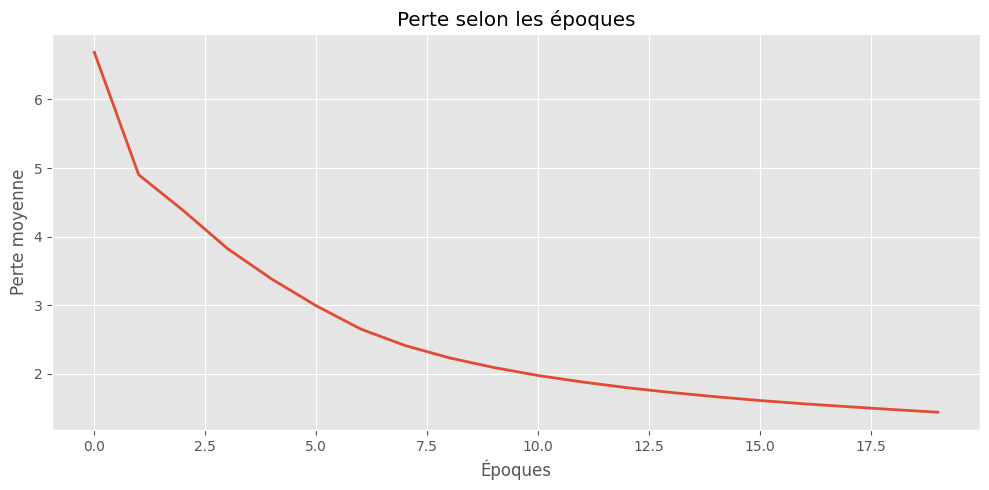

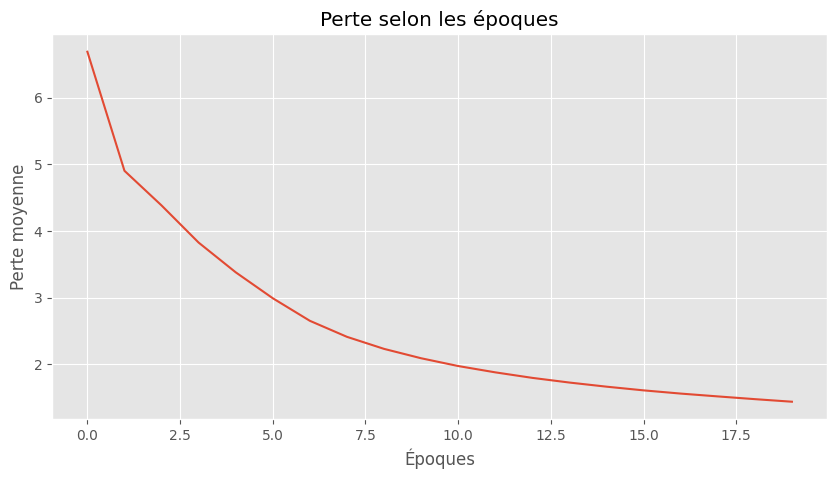

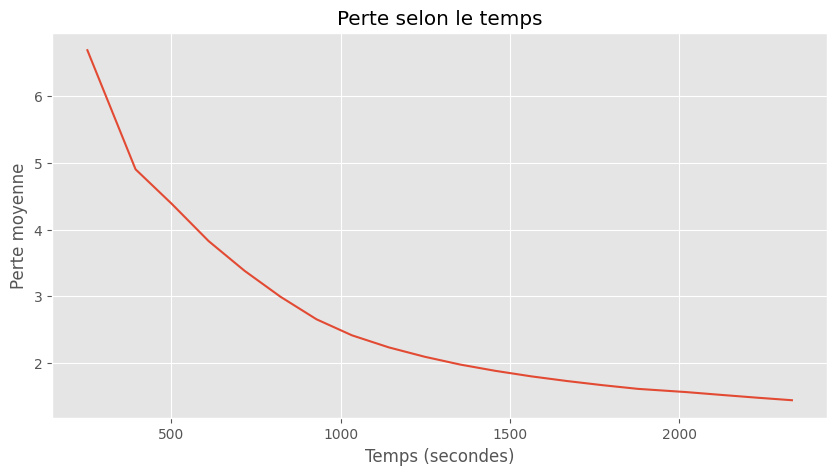

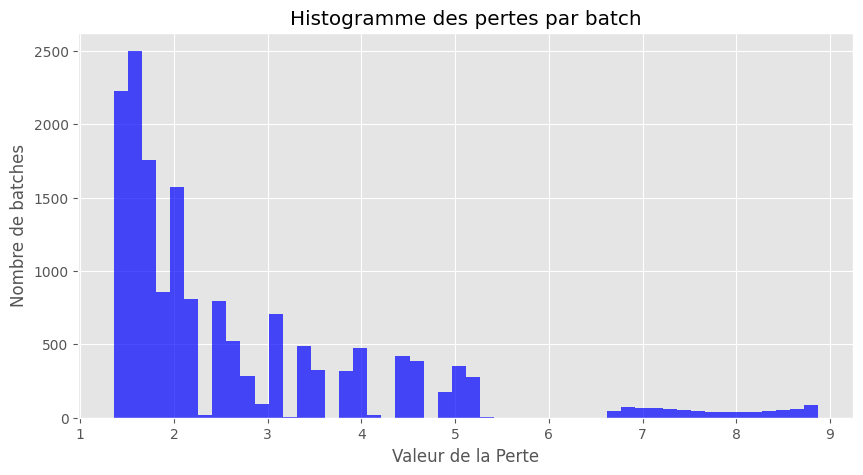

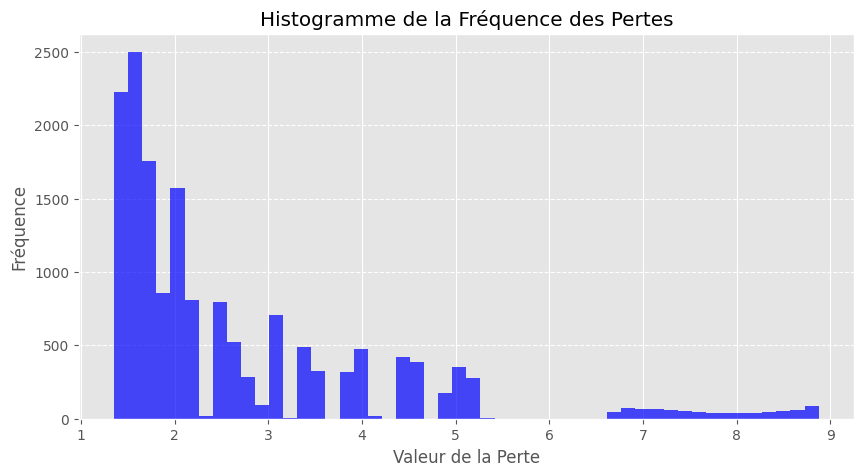

In [19]:
# Visualisation après l'entraînement

# Setting a consistent style
plt.style.use('ggplot')

# Perte selon les époques
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, linewidth=2)
plt.xlabel('Époques')
plt.ylabel('Perte moyenne')
plt.title('Perte selon les époques')
plt.tight_layout()
plt.show()

# Perte selon les époques
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses)
plt.xlabel('Époques')
plt.ylabel('Perte moyenne')
plt.title('Perte selon les époques')
plt.show()

# Perte selon le temps
cumulative_times = [sum(epoch_times[:i+1]) for i in range(len(epoch_times))]
plt.figure(figsize=(10, 5))
plt.plot(cumulative_times, epoch_losses)
plt.xlabel('Temps (secondes)')
plt.ylabel('Perte moyenne')
plt.title('Perte selon le temps')
plt.show()

# Histogramme des pertes pour tous les batches
plt.figure(figsize=(10, 5))
plt.hist(batch_losses, bins=50, facecolor='blue', alpha=0.7)
plt.xlabel('Valeur de la Perte')
plt.ylabel('Nombre de batches')
plt.title('Histogramme des pertes par batch')
plt.show()

# Histogramme de la fréquence des pertes
plt.figure(figsize=(10, 5))
plt.hist(batch_losses, bins=50, facecolor='blue', alpha=0.7)
plt.xlabel('Valeur de la Perte')
plt.ylabel('Fréquence')
plt.title('Histogramme de la Fréquence des Pertes')
plt.grid(axis='y', linestyle='--')
plt.show()


### Exécuter l'inférence



**Aspect théorique** :

L'inférence fait référence au processus d'utilisation d'un modèle déjà formé pour faire des prédictions sur de nouvelles données inédites. Dans ce contexte, l'inférence concerne la traduction de phrases d'une langue à une autre.

**Aspect pratique** :

1. **Classe Translator** : Cette classe est conçue pour encapsuler la logique de traduction. Elle prend en entrée des tokenizers (pour le portugais et l'anglais) et un modèle transformateur.

2. **Traitement de la Phrase d'Entrée** : La fonction `__call__` prend une phrase en entrée et la convertit en une séquence de tokens. Elle s'assure que l'entrée est un tenseur et l'encode à l'aide du tokenizer portugais.

3. **Initialisation des Tokens de Début et de Fin** : Les tokens de début et de fin pour l'anglais sont initialisés pour guider le processus de traduction.

4. **Boucle de Traduction** : Une boucle est exécutée pour générer la traduction, token par token. À chaque itération, le modèle prédit le token suivant en se basant sur les tokens précédents.

5. **Détokenisation** : Une fois que la séquence est complète (ou que le token de fin est rencontré), la séquence est convertie en texte en utilisant le tokenizer anglais.

6. **Extraction des Poids d'Attention** : Les poids d'attention du modèle transformateur sont également extraits. Ils peuvent être utilisés pour analyser quelles parties de la phrase d'entrée le modèle a le plus "regardées" lors de la traduction.

7. **Affichage des Traductions** : La fonction `print_translation` permet d'afficher l'entrée, la traduction prédite et la vérité terrain (traduction correcte).

8. **Exemple** : Enfin, un exemple de traduction est fourni. Une phrase est traduite et le résultat est affiché.

Cet exemple montre comment utiliser un modèle transformateur formé pour traduire des phrases du français au portugais. La structure permet d'intégrer facilement d'autres phrases ou de modifier la logique de traduction si nécessaire.

In [20]:
# Définition de la classe Translator pour effectuer la traduction
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # Traitement de la phrase d'entrée
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]
    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    encoder_input = sentence

    # Initialisation des tokens de début et de fin pour l'anglais
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    # Boucle pour générer la traduction
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      predictions = predictions[:, -1:, :]
      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    # Récupération et détokenisation du texte traduit
    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]
    tokens = tokenizers.en.lookup(output)[0]

    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)
    return text, tokens, attention_weights

translator = Translator(tokenizers, transformer)

# Fonction pour afficher les résultats de traduction
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Entrée":15s}: {sentence}')
  print(f'{"Prédiction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Vérité terrain":15s}: {ground_truth}')

# Exemples de traductions
sentence = "este é um problema que temos que resolver."
ground_truth = "c'est un problème que nous devons résoudre."
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)


Entrée         : este é um problema que temos que resolver.
Prédiction     : this is a problem that we have to solve .
Vérité terrain : c'est un problème que nous devons résoudre.


In [21]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Entrée         : os meus vizinhos ouviram sobre esta ideia.
Prédiction     : my neighbors heard about this idea .
Vérité terrain : and my neighboring homes heard about this idea .


In [22]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Entrée         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prédiction     : so i ' m going to go very quickly share with you a few stories of magic things that happened
Vérité terrain : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Tracés d'attention



**Aspect théorique** :

Le mécanisme d'attention est une innovation clé dans le domaine du traitement automatique de la langue naturelle. Il permet à un modèle, comme le Transformer, de se "concentrer" sur différentes parties d'une séquence d'entrée lorsqu'il produit une séquence de sortie. Les tracés d'attention visualisent ces poids, donnant une idée de quelle partie de l'entrée le modèle considère comme la plus pertinente à chaque étape de la production de la séquence de sortie.

**Aspect pratique** :

1. **Définition de la Phrase et de sa Traduction** : Une phrase en français est définie, ainsi que sa traduction correcte en portugais.

2. **Obtention de la Traduction Prédite** : Le modèle traduit la phrase et retourne la traduction prédite et les poids d'attention.

3. **Tracer une Tête d'Attention** : La fonction `plot_attention_head` permet de visualiser les poids d'attention pour une tête d'attention spécifique.

4. **Visualisation Globale** : La fonction `plot_attention_weights` utilise la fonction précédente pour tracer les poids d'attention de toutes les têtes d'attention dans une certaine couche du modèle. Cela offre une vue d'ensemble de ce sur quoi le modèle se concentre à chaque étape de la traduction.

5. **Test avec D'autres Phrases** : Le processus est répété avec une nouvelle phrase pour montrer comment les poids d'attention peuvent varier selon les entrées.

Cet exemple illustre l'importance de visualiser les poids d'attention pour comprendre le fonctionnement interne d'un modèle Transformer. En visualisant les poids, on peut obtenir des insights sur les zones d'attention du modèle et, potentiellement, améliorer sa performance ou son architecture.

Entrée         : eu estou olhando para ver como meu modelo funciona.
Prédiction     : i ' m looking at how my model works .
Vérité terrain : i'm looking to see how my model works.


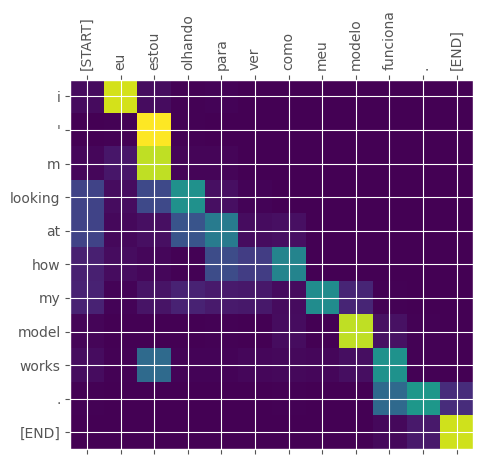

In [27]:
# Définir une phrase en portugais et sa traduction réelle en anglais
sentence = "eu estou olhando para ver como meu modelo funciona."
ground_truth = "i'm looking to see how my model works."

# Utilisez le traducteur pour obtenir la traduction prédite et les poids d'attention
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

def plot_attention_head(in_tokens, translated_tokens, attention):
  """Trace les poids d'attention pour une tête spécifique."""

  # Le modèle n'a pas généré `<START>` dans la sortie. On le saute.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

# Sélectionnez une tête d'attention spécifique pour la visualisation
head = 0
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]

# Convertir la phrase d'entrée en tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

# Tracer les poids d'attention pour la tête sélectionnée
plot_attention_head(in_tokens, translated_tokens, attention)


Entrée         : atualmente estou testando o treinamento do meu modelo.
Prédiction     : i ' m currently testing my model .
Vérité terrain : i'm currently testing the training of my model.


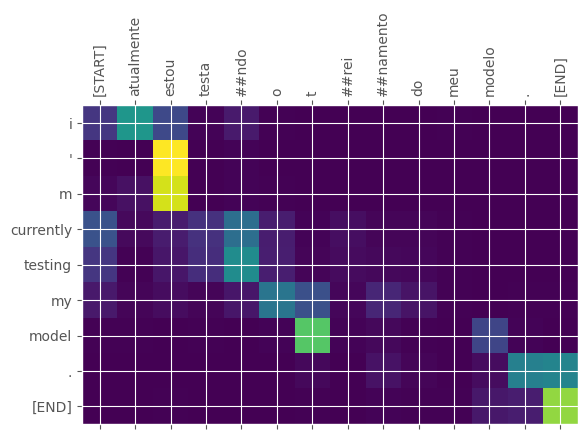

In [28]:
# Définir une phrase en portugais et sa traduction réelle en anglais
sentence = "atualmente estou testando o treinamento do meu modelo."
ground_truth = "i'm currently testing the training of my model."

# Utilisez le traducteur pour obtenir la traduction prédite et les poids d'attention
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

def plot_attention_head(in_tokens, translated_tokens, attention):
  """Trace les poids d'attention pour une tête spécifique."""

  # Le modèle n'a pas généré `<START>` dans la sortie. On le saute.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

# Sélectionnez une tête d'attention spécifique pour la visualisation
head = 0
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]

# Convertir la phrase d'entrée en tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

# Tracer les poids d'attention pour la tête sélectionnée
plot_attention_head(in_tokens, translated_tokens, attention)


Entrée         : Minhas paixões são matemática e ciência da computação.
Prédiction     : my passions are mathematics and computer science .
Vérité terrain : My passions are mathematics and computer science.


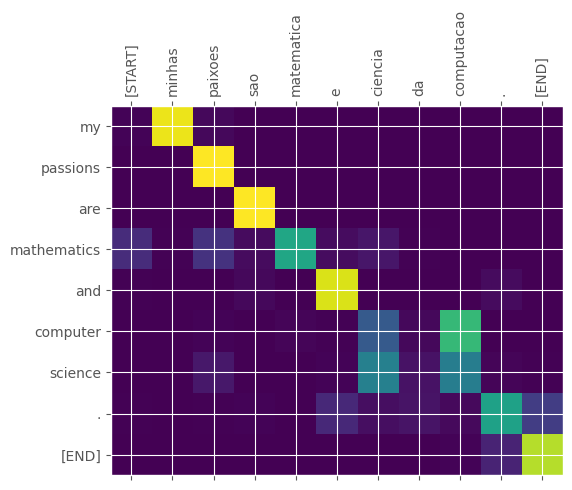

In [34]:
# Définir une phrase en portugais et sa traduction réelle en anglais
sentence = "Minhas paixões são matemática e ciência da computação."
ground_truth = "My passions are mathematics and computer science."

# Utilisez le traducteur pour obtenir la traduction prédite et les poids d'attention
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

def plot_attention_head(in_tokens, translated_tokens, attention):
  """Trace les poids d'attention pour une tête spécifique."""

  # Le modèle n'a pas généré `<START>` dans la sortie. On le saute.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

# Sélectionnez une tête d'attention spécifique pour la visualisation
head = 0
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]

# Convertir la phrase d'entrée en tokens
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

# Tracer les poids d'attention pour la tête sélectionnée
plot_attention_head(in_tokens, translated_tokens, attention)


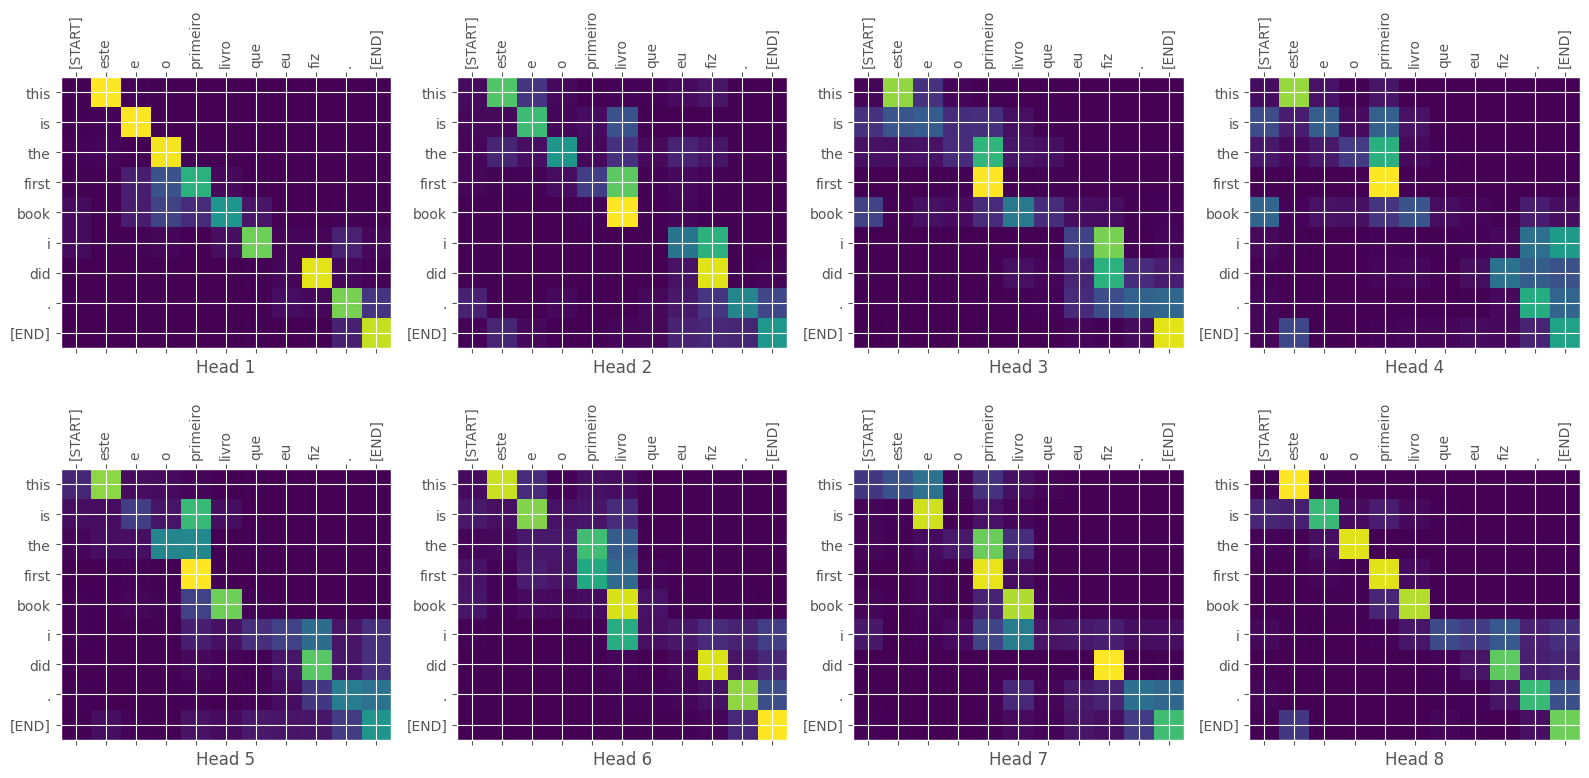

In [24]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  """Trace les poids d'attention pour toutes les têtes."""

  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Entrée         : Eu li sobre triceratops na enciclopédia.
Prédiction     : i read about tribroparts in encyclopedia .
Vérité terrain : I read about triceratops in the encyclopedia.


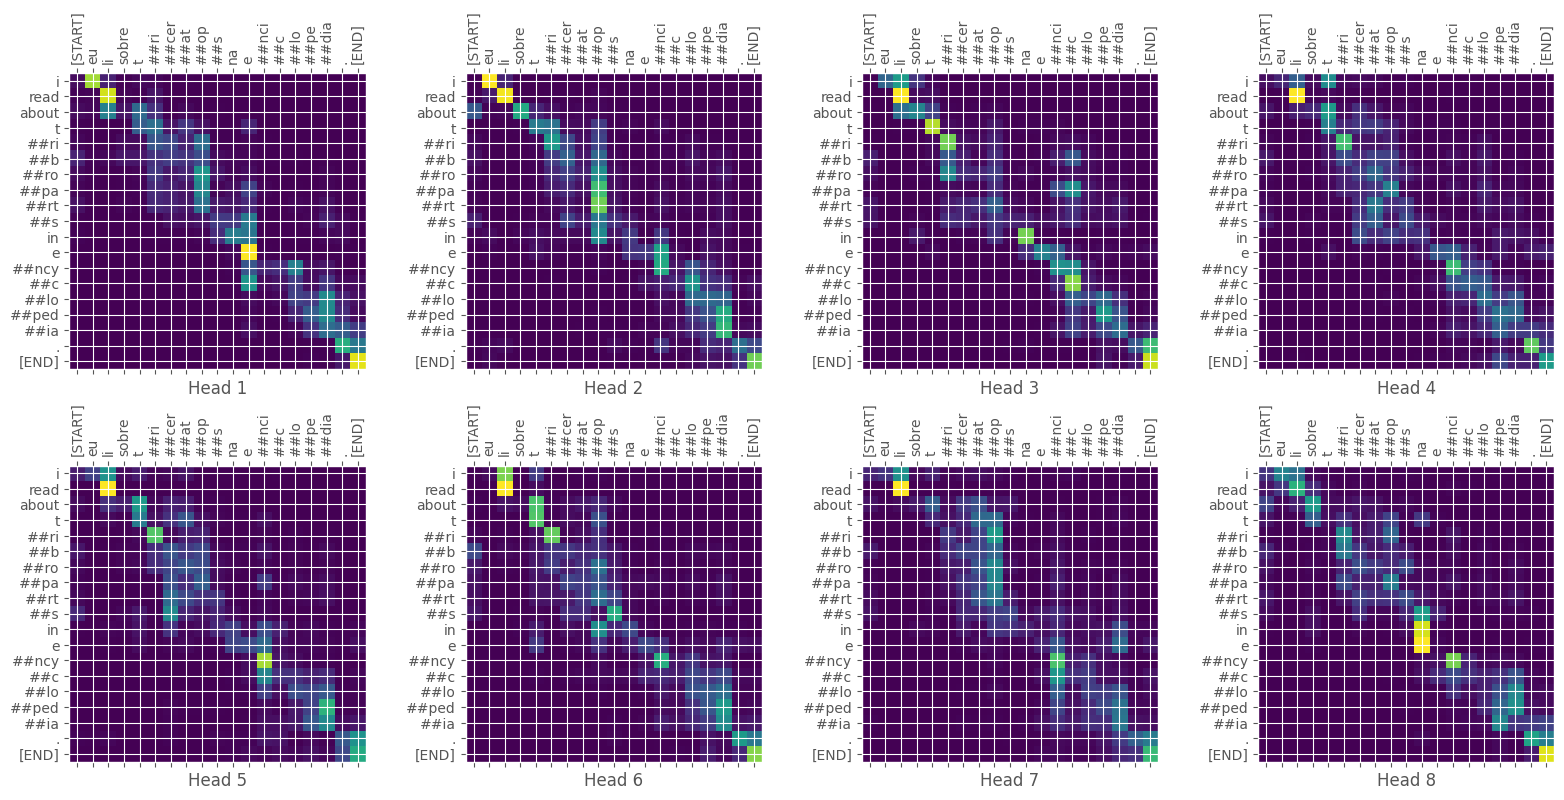

In [25]:
# Testez avec une autre phrase
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Entrée         : Minhas paixões são matemática e ciência da computação.
Prédiction     : my passions are mathematics and computer science .
Vérité terrain : My passions are mathematics and computer science.


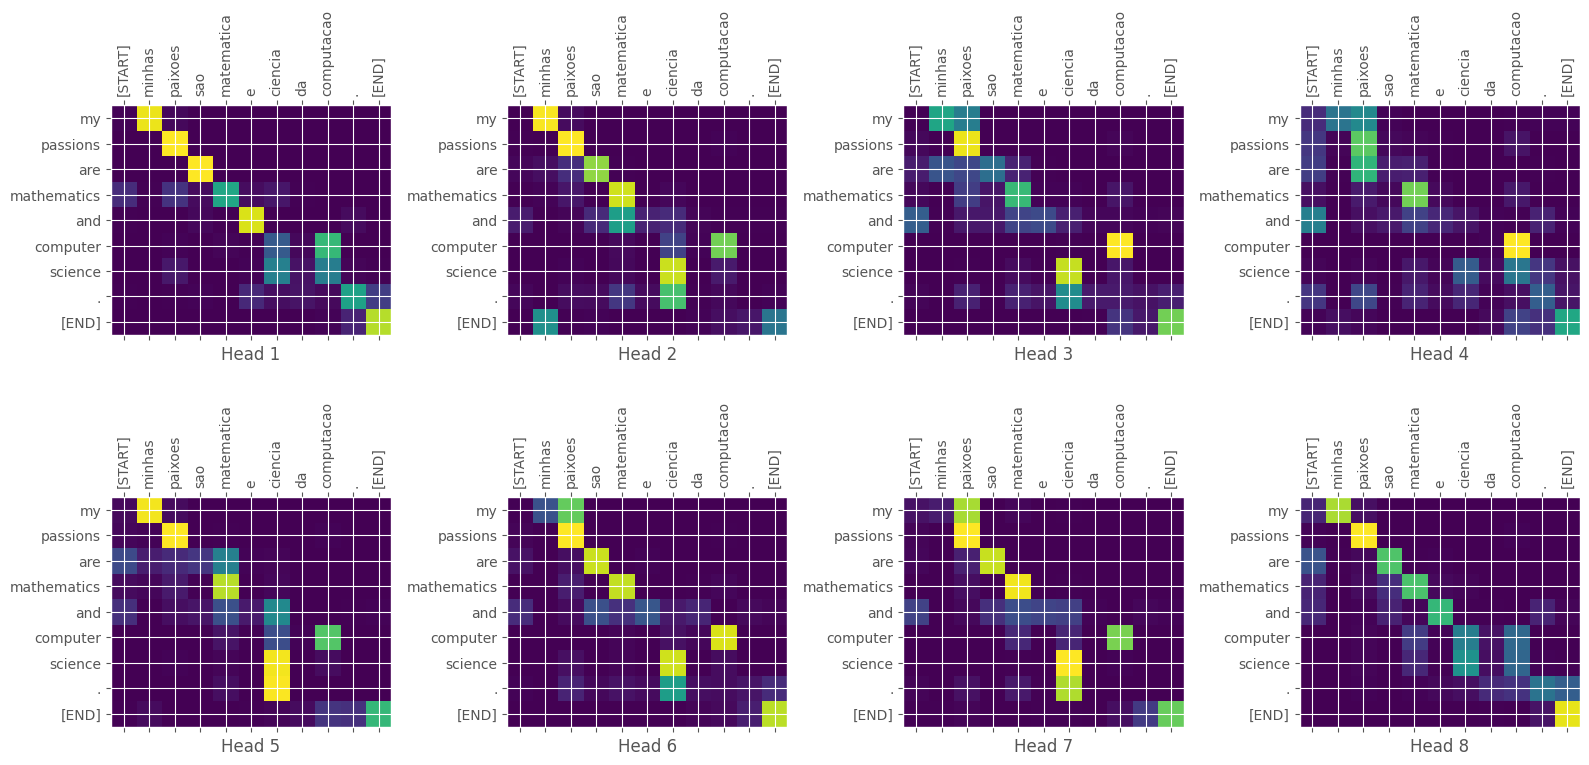

In [33]:
sentence = "Minhas paixões são matemática e ciência da computação."
ground_truth = "My passions are mathematics and computer science."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])